## Equal frequency discretisation

**Equal frequency discretisation** divides the scope of possible values of the variable into N bins, where **each bin carries the same amount of observations**. This is particularly useful for **skewed variables** as it spreads the observations over the different bins equally. We find the interval boundaries **by determining the quantiles**. It consists of **dividing the continuous variable into N quantiles**, N to be defined by the user. **Equal frequency binning** is straightforward to implement and by spreading the values of the observations more evenly it may help **boost the algorithm's performance**. This arbitrary binning may also **disrupt the relationship with the target.

## Titanic dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.discretisation import EqualFrequencyDiscretiser

**Load the numerical variables of the Titanic Dataset!**

In [2]:
data = pd.read_csv('titanic.csv', usecols=['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((916, 2), (393, 2))

The variables Age and Fare contain missing data, that I will fill by extracting a random sample of the variable.

**Function to fill NA with a random sample! Random sampling! Extract the random sample to fill the na! Pandas needs to have the same index in order to merge datasets!**

In [4]:
def impute_na(data, variable):
    df = data.copy()
    df[variable+'_random'] = df[variable]
    random_sample = X_train[variable].dropna().sample(
        df[variable].isnull().sum(), random_state=0)
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    return df[variable+'_random']

**Replace NA in both train and test sets!**

In [5]:
X_train['age'] = impute_na(X_train, 'age')
X_test['age'] = impute_na(X_test, 'age')
X_train['fare'] = impute_na(X_train, 'fare')
X_test['fare'] = impute_na(X_test, 'fare')

**Explore the distribution of age!**

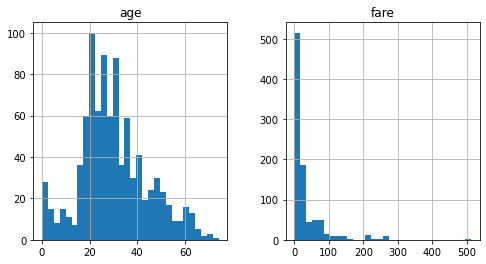

In [6]:
X_train[['age', 'fare']].hist(bins=30, figsize=(8,4))
plt.show()

## Equal frequency discretisation with pandas and NumPy

The interval limits are the quantile limits. We can find those out with pandas qcut.

**Use pandas qcut (quantile cut) and I indicate that we want 10 bins. retbins = True indicates that I want to capture the limits of each interval (so I can then use them to cut the test set)**

In [7]:
Age_disccretised, intervals = pd.qcut(
    X_train['age'], 10, labels=None, retbins=True, precision=3, duplicates='raise')
pd.concat([Age_disccretised, X_train['age']], axis=1).head(10)

,age,age
501,"(0.166, 16.0]",13.0
588,"(0.166, 16.0]",4.0
402,"(28.0, 31.0]",30.0
1193,"(36.0, 42.0]",40.5
686,"(20.0, 22.0]",22.0
971,"(36.0, 42.0]",39.0
117,"(28.0, 31.0]",30.0
540,"(0.166, 16.0]",2.0
294,"(42.0, 50.0]",49.0
261,"(31.0, 36.0]",35.0


We can see in the above output how by discretising using quantiles, we placed each Age observation within one interval. For example, age 30 was placed in the 28-31 interval, whereas age 49 was placed into the 42-50 interval. Note how the interval widths are different. We can visualise the interval cut points below:

In [8]:
intervals

array([ 0.1667, 16.    , 20.    , 22.    , 25.    , 28.    , 31.    ,
       36.    , 42.    , 50.    , 74.    ])

And because we generated the bins using the quantile cut method, we should have roughly the same amount of observations per bin. See below.

**Roughly the same number of passengers per interval!**

In [9]:
Age_disccretised.value_counts()

(0.166, 16.0]    106
(31.0, 36.0]     106
(16.0, 20.0]      92
(22.0, 25.0]      92
(25.0, 28.0]      92
(28.0, 31.0]      90
(42.0, 50.0]      90
(36.0, 42.0]      85
(20.0, 22.0]      82
(50.0, 74.0]      81
Name: age, dtype: int64

**Add labels instead of having the interval boundaries, to the bins, as follows:**

In [10]:
labels = ['Q'+str(i) for i in range(1,11)]
labels

['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10']

In [11]:
Age_disccretised, intervals = pd.qcut(X_train['age'], 10, labels=labels,
                                      retbins=True,
                                      precision=3, duplicates='raise')
Age_disccretised.head()

501     Q1
588     Q1
402     Q6
1193    Q8
686     Q3
Name: age, dtype: category
Categories (10, object): ['Q1' < 'Q2' < 'Q3' < 'Q4' ... 'Q7' < 'Q8' < 'Q9' < 'Q10']

**To apply the intervals to the test set, we need to extend the limits of the outer bins to -inf and +inf, so that if in the test set, there are smaller or bigger values than the minimum or maximum values in the train set, they can be accomodated in the outer intervals. Otherwise, they will be replaced by NaN! Prepend/Append infinities to accommodate outliers!**

In [12]:
intervals[0] = float("-inf")
intervals[len(intervals) - 1] = float("inf")
intervals

array([-inf,  16.,  20.,  22.,  25.,  28.,  31.,  36.,  42.,  50.,  inf])

**Transform the test set: we use pandas cut method (instead of qcut) and pass the quantile edges calculated in the training set!**

In [13]:
X_test['Age_disc_label'] = pd.cut(x = X_test['age'], bins=intervals, labels=labels)
X_test['Age_disc'] = pd.cut(x = X_test['age'], bins=intervals)
X_test.head(10)

,age,fare,Age_disc_label,Age_disc
1139,38.0,7.8958,Q8,"(36.0, 42.0]"
533,21.0,21.0000,Q3,"(20.0, 22.0]"
459,42.0,27.0000,Q8,"(36.0, 42.0]"
1150,3.0,14.5000,Q1,"(-inf, 16.0]"
393,25.0,31.5000,Q4,"(22.0, 25.0]"
1189,4.0,16.7000,Q1,"(-inf, 16.0]"
5,48.0,26.5500,Q9,"(42.0, 50.0]"
231,52.0,30.5000,Q10,"(50.0, inf]"
330,57.0,13.0000,Q10,"(50.0, inf]"
887,31.0,8.1125,Q6,"(28.0, 31.0]"


In [14]:
X_test['Age_disc_label'].isnull().sum()

0

**Check that we have equal frequency (equal number of observations per bin) !**

<AxesSubplot:xlabel='Age_disc'>

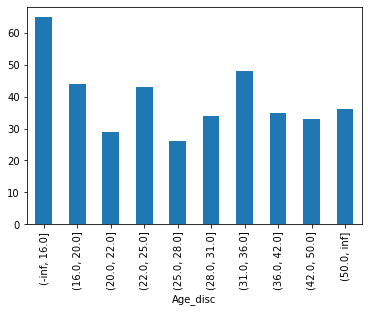

In [15]:
X_test.groupby('Age_disc')['age'].count().plot.bar()

We can see that the top intervals have less observations. This may happen with skewed distributions if we try to divide in a high number of intervals. To make the value spread  more homogeneous, we should discretise in less intervals.

## Equal frequency discretisation with Feature-Engine

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((916, 2), (393, 2))

**Replace NA in both  train and test sets!**

In [17]:
X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')
X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

**With feature engine we can automate the process for many variables in one line of code!**

In [18]:
disc = EqualFrequencyDiscretiser(q=10, variables = ['age', 'fare'])
disc.fit(X_train)

EqualFrequencyDiscretiser(variables=['age', 'fare'])

**In the binner dict, we can see the limits of the intervals. Note that the intervals have different widths!**

In [19]:
disc.binner_dict_

{'age': [-inf,
  16.0,
  20.0,
  22.25000000000003,
  25.0,
  28.0,
  31.0,
  36.0,
  42.0,
  50.0,
  inf],
 'fare': [-inf,
  7.55,
  7.7958,
  8.05,
  10.5,
  14.4542,
  21.075,
  26.55,
  40.125,
  79.025,
  inf]}

**Transform train and text!**

In [20]:
train_t = disc.transform(X_train)
test_t = disc.transform(X_test)

In [21]:
train_t.head()

,age,fare
501,0,5
588,0,6
402,5,4
1193,2,1
686,2,1


**Explore the number of observations per bucket!**

Text(0, 0.5, 'Number of observations per bin')

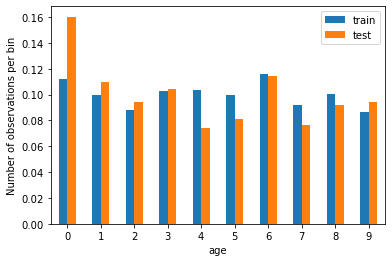

In [22]:
t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

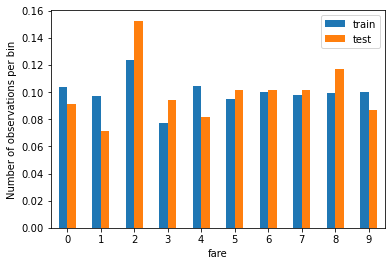

In [23]:
t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Note how equal frequency discretisation obtains a better value spread across the different intervals.

## Equal frequency discretisation with Scikit-learn

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],
    data['survived'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((916, 2), (393, 2))

**Replace NA in both  train and test sets!**

In [25]:
X_train['age'] = impute_na(data, 'age')
X_test['age'] = impute_na(data, 'age')
X_train['fare'] = impute_na(data, 'fare')
X_test['fare'] = impute_na(data, 'fare')

In [26]:
disc = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
disc.fit(X_train[['age', 'fare']])

KBinsDiscretizer(encode='ordinal', n_bins=10)

In [27]:
disc.bin_edges_

array([array([ 0.1667, 16.    , 20.    , 22.25  , 25.    , 28.    , 31.    ,
              36.    , 42.    , 50.    , 74.    ])                          ,
       array([  0.    ,   7.55  ,   7.7958,   8.05  ,  10.5   ,  14.4542,
               21.075 ,  26.55  ,  40.125 ,  79.025 , 512.3292])         ],
      dtype=object)

In [28]:
train_t = disc.transform(X_train[['age', 'fare']])
train_t = pd.DataFrame(train_t, columns = ['age', 'fare'])
train_t.head()

,age,fare
0,0.0,5.0
1,0.0,6.0
2,5.0,4.0
3,2.0,1.0
4,2.0,1.0


In [29]:
test_t = disc.transform(X_test[['age', 'fare']])
test_t = pd.DataFrame(test_t, columns = ['age', 'fare'])

Text(0, 0.5, 'Number of observations per bin')

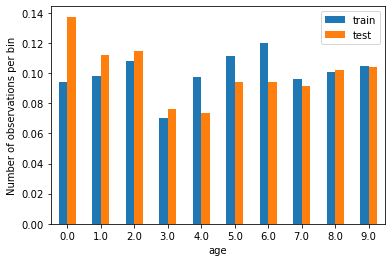

In [30]:
t1 = train_t.groupby(['age'])['age'].count() / len(train_t)
t2 = test_t.groupby(['age'])['age'].count() / len(test_t)
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

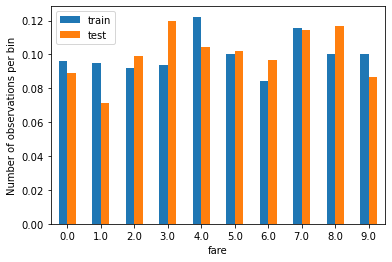

In [31]:
t1 = train_t.groupby(['fare'])['fare'].count() / len(train_t)
t2 = test_t.groupby(['fare'])['fare'].count() / len(test_t)
tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['train', 'test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')